In [1]:

%%capture
!pip install faiss-cpu sentence-transformers langchain langchain_community langchain-huggingface langchain-ollama


In [2]:
import pandas as pd
from langchain.vectorstores import FAISS
from langchain.embeddings import HuggingFaceEmbeddings

# Load your CSV dataset
df = pd.read_csv('/mnt/f/datasets/data.csv')

# Filter for valid full content
texts = df['full_content'].dropna().sample(n=100, random_state=42).tolist()

# Show how many articles we kept
print(f"Using {len(texts)} non-null articles for the vector store.")

# Initialize embeddings and build FAISS index
embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")
vectorstore = FAISS.from_texts(texts, embeddings)


Using 100 non-null articles for the vector store.


/tmp/ipykernel_197702/1476988221.py:15: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")


In [48]:

from langchain_ollama import OllamaLLM
from langchain.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser

llm = OllamaLLM(model="mistral")

krag_template = PromptTemplate(
    input_variables=["context", "triples", "question"],
    template="""
Context:
{context}

Knowledge Graph Triples:
{triples}

Question:
{question}

Answer:
""")

krag_chain = krag_template | llm | StrOutputParser()

rag_template = PromptTemplate(
    input_variables=["context", "question"],
    template="""
Context:
{context}

Question:
{question}

Answer:
""")

rag_chain = rag_template | llm | StrOutputParser()


In [49]:
import spacy
import networkx as nx
from sentence_transformers import SentenceTransformer
import numpy as np
import faiss

# Load SpaCy model
nlp = spacy.load("en_core_web_sm")

# Extract subject-predicate-object triples from each sentence
def extract_relationships(doc):
    relationships = []
    for sent in doc.sents:
        root = sent.root
        subj = next((child for child in root.children if child.dep_ == "nsubj"), None)
        obj = next((child for child in root.children if child.dep_ in ["dobj", "pobj"]), None)
        if subj and obj:
            relationships.append((subj.text, root.lemma_, obj.text))
    return relationships

# Build KG with NetworkX
G = nx.DiGraph()
all_triples = []

for text in texts:  # 'texts' is your list of sampled full_content entries
    doc = nlp(text)
    triples = extract_relationships(doc)
    all_triples.extend(triples)
    for subj, pred, obj in triples:
        G.add_edge(subj, obj, relation=pred)

# Prepare for embedding
triple_texts = [f"{s} —[{p}]→ {o}" for s, p, o in G.edges(data="relation")]
triple_tuples = [(s, p, o) for s, o, p in G.edges(data="relation")]

# Embed triples using sentence-transformers
embedder = SentenceTransformer("all-MiniLM-L6-v2")
triple_embeddings = embedder.encode(triple_texts)

# Build FAISS index for triple search
index = faiss.IndexFlatL2(triple_embeddings.shape[1])
index.add(np.array(triple_embeddings))


In [50]:
# show KG 
import matplotlib.pyplot as plt

# plt.figure(figsize=(10, 7))
# pos = nx.spring_layout(G, k=0.5)
# nx.draw(G, pos, with_labels=True, node_size=500, font_size=8)
# edge_labels = nx.get_edge_attributes(G, 'relation')
# nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7)
# plt.title("KG")
# plt.show()

In [76]:
# Limit to top N nodes by degree (most connected)
N = 50
degree_dict = dict(G.degree())
top_nodes = sorted(degree_dict, key=degree_dict.get, reverse=True)[:N]
subgraph = G.subgraph(top_nodes)

# plt.figure(figsize=(12, 9))
# pos = nx.spring_layout(subgraph, k=0.7)
# nx.draw(subgraph, pos, with_labels=True, node_size=800, font_size=9, node_color="#69b3a2")
# edge_labels = nx.get_edge_attributes(subgraph, 'relation')
# nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=edge_labels, font_size=7)
# plt.title("Top 50 Entity Knowledge Graph")
# plt.axis('off')
# plt.show()

In [91]:
# Format triples for LLM prompt
def format_triples(triples):
    return [f"{s} —[{p}]→ {o}" for s, p, o in triples]

# Score recall based on how many ground truth triples are reflected in the answer for KRAG 
def score_recall_KRAG(triples, answer):
    total_parts = 0
    matched_parts = 0
    for s, p, o in triples:
        for part in [s, p, o]: # GT Subject, predicate, and object 
            total_parts += 1
            if part.lower() in answer.lower(): # if the subject, predicate, and object ground truth appear in LLM answer, then increment recall score
                # print("triple used: ", part.lower())
                matched_parts += 1
    print("Triple Count:", matched_parts) # threshold 
    return matched_parts / total_parts if total_parts else 0, matched_parts # matched_parts for triples found 

# Score recall based on how well ground truth context is reflected in the answer for RAG 
def score_recall_RAG(context, answer): 
    print("number of words in context also in answer: ", sum(1 for word in answer.split() if word.lower() in context.lower())) # threshold 
    return sum(1 for word in answer.split() if word.lower() in context.lower()) / len(answer.split())
    
# Retrieve documents and generate an answer with context
def rag_query(question, k = 2):
    # search vectorstore for embedded text chunks from dataset (articles, reports, etc.)
    # retrieve K most semantically similar chunks, contatenate into string, input to LLM with question 
    docs = vectorstore.similarity_search(question, k=k) 
    context = "\n".join([doc.page_content for doc in docs])
    answer = rag_chain.invoke({"context": context, "question": question}).strip()
    return answer, context


def krag_query(question, k=5):
    # Embed the question and retrieve top-k triples from FAISS
    q_embed = embedder.encode([question])
    _, I = index.search(np.array(q_embed), k)
    
    # Get the matching triples
    retrieved_triples = [triple_tuples[i] for i in I[0]]
    triples_text = "\n".join(format_triples(retrieved_triples))

    # Retrieve vectorstore context as usual
    context = "\n".join([doc.page_content for doc in vectorstore.similarity_search(question, k=2)])

    # Run the LLM with context and embedding-retrieved triples
    # print("Ground Truth Triples:", retrieved_triples)
    answer = krag_chain.invoke({"context": context, "triples": triples_text, "question": question}).strip()

    return answer, retrieved_triples



In [92]:
# Generate sample questions based on entities in KG 
sample_entities = list(G.nodes())[:10]

questions = [f"What does {entity} do?" for entity in sample_entities]

# Optionally preview them
for q in questions:
    print("-", q)


- What does Ltd. do?
- What does stake do?
- What does fund do?
- What does shares do?
- What does % do?
- What does MD do?
- What does position do?
- What does LLC do?
- What does Bank do?
- What does Management do?


In [99]:
evals = [] 

for q in questions:
    print(f"Question: {q}")

    rag_answer, rag_context = rag_query(q)
    krag_answer, ground_truth = krag_query(q)

    krag_recall, triples_found = score_recall_KRAG(ground_truth, krag_answer)
    rag_recall = score_recall_RAG(rag_context, rag_answer)

    # print(f"  RAG Answer:  {rag_answer}")
    # print(f"  kRAG Answer: {krag_answer}")

    # recall logging 
    # print(f"  KRAG Recall from triples: {krag_recall:.2f}\n")
    # print(f"  RAG Recall from context: {rag_recall:.2f}\n")

    rag_match_words = sum(1 for word in rag_answer.split() if word.lower() in rag_context.lower())

    evals.append({
        "question": q,
        "triples": triples_found,
        "krag_recall": krag_recall,
        "rag_match_words": rag_match_words,
        "rag_recall": rag_recall
    })

# convert evals to df for graphing 
df = pd.DataFrame(evals)

Question: What does Ltd. do?
Triple Count: 3
number of words in context also in answer:  125
Rag match:  125
Question: What does stake do?
Triple Count: 11
number of words in context also in answer:  58
Rag match:  58
Question: What does fund do?
Triple Count: 10
number of words in context also in answer:  34
Rag match:  34
Question: What does shares do?
Triple Count: 15
number of words in context also in answer:  40
Rag match:  40
Question: What does % do?
Triple Count: 15
number of words in context also in answer:  81
Rag match:  81
Question: What does MD do?
Triple Count: 6
number of words in context also in answer:  43
Rag match:  43
Question: What does position do?
Triple Count: 13
number of words in context also in answer:  29
Rag match:  29
Question: What does LLC do?
Triple Count: 12
number of words in context also in answer:  67
Rag match:  67
Question: What does Bank do?
Triple Count: 14
number of words in context also in answer:  81
Rag match:  81
Question: What does Managem

### So now a good thing to graph would be how the triples found in ground truth increases the KRAG recall and how the number of words in context that are also in answer increase the RAG recall to see the influence of both 

### We can see here that 5 triples found in ground truth does not increase KRAG recall above RAG recall by a significant margin, but when we find 9 triples in ground truth we near RAG recall with 60%

### As the number of retrieved triples increases, KRAG's recall improves and begins to rival or surpass RAG — depending on how well those triples cover the answer space 

### Is there a triple threshold where KRAG surpasses RAG recall? 

# 1st graph 
The number of triples in the answer increases the KRAG Recall 

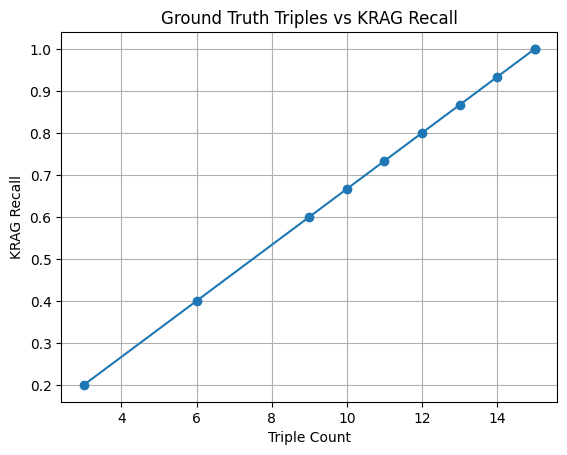

In [102]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame(evals)

# sort df's for KRAG and RAG 
df_krag = df.sort_values(by="triples", ascending=True)
df_rag = df.sort_values(by="rag_match_words", ascending=True)


# Plot 1: Ground Truth Triples vs KRAG Recall
plt.plot(df_krag["triples"], df_krag["krag_recall"], marker="o")
plt.title("Ground Truth Triples vs KRAG Recall")
plt.xlabel("Triple Count")
plt.ylabel("KRAG Recall")
plt.grid(True)
plt.show()

# 2nd graph 
Matching more words is good — but only if the answer stays tight and grounded.

Longer, wordier answers can dilute recall — even if they pull more correct words from context.

RAG recall measures precision of the answer relative to its source, not total coverage

Fighting hallucination 

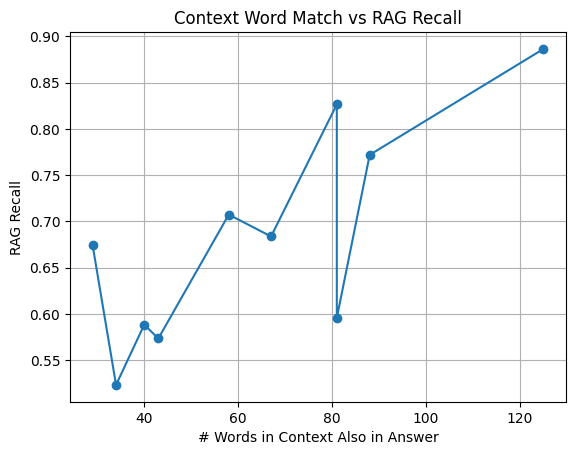

In [103]:
# Plot 2: Context Match Words vs RAG Recall
plt.plot(df_rag["rag_match_words"], df_rag["rag_recall"], marker="o")
plt.title("Context Word Match vs RAG Recall")
plt.xlabel("# Words in Context Also in Answer")
plt.ylabel("RAG Recall")
plt.grid(True)
plt.show()

# 3rd graph 

KRAG Recall threshold of 0.4? 

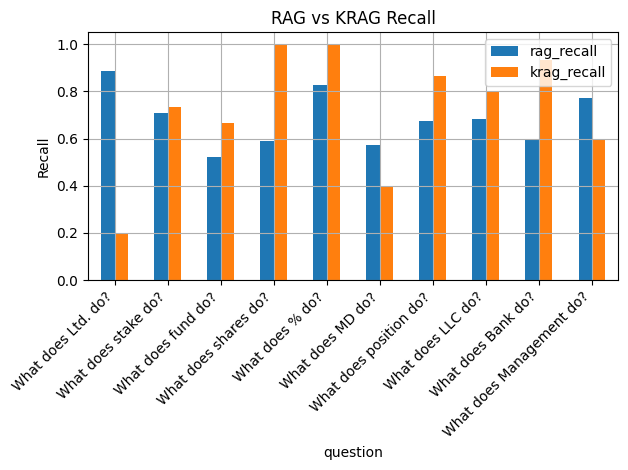

In [104]:
# Plot 3: RAG vs KRAG Recall by Question
df.plot(x="question", y=["rag_recall", "krag_recall"], kind="bar")
plt.title("RAG vs KRAG Recall")
plt.ylabel("Recall")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.grid(True)
plt.show()